Here is the the solution that allowed me to score ~ 0.1250 on this competition

I'll skip the basic data exploration, since you can find it in many tutorials and jump directly to data munging and analysis

Using the ensemble regressor method, my best score was 0.12594 (rank 663 as of end 07/17). This requires some fine tuning of the parameters and different data transformations : I'll leave it to you as an exercise 

For information, the notebook was run on a ryzen 7 processor running at 3.7 GHz

# Importation of all needed modules

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import myplots
import seaborn as sns
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import Lasso, ElasticNet, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest, AdaBoostRegressor

from sklearn import metrics
from sklearn.metrics import r2_score

import xgboost as xgb
from xgboost import XGBRegressor

from scipy.stats import boxcox
import time

C:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# "Home-made" functions 

In [2]:
#Two functions that create dummy variables
#Just needs the DataFrame to be encoded
def dummy(data):
    data = pd.get_dummies(data)
    return data

#All missing values for categorical features will be labelled as "None"
def cat_null_values(dat,feat):
    dat.loc[dat[feat].isnull(), feat] = "None"

#Replace numeric null values by their mean (or zero)
def numeric_null_values(dat,feat):
    dat.loc[dat[feat].isnull(),feat] = np.mean(dat[feat])
    #dat.loc[dat[feat].isnull(),feat] = 0

#Cross validation score for a model for selected features
def cross_val(model,data,features):
    scores = (cross_val_score(model,data[features],data["SalePrice"],cv=5,n_jobs=1)).mean()
    return scores

#Scoring method for this competition
#true = actual "SalePrice", pred = predicted "SalePrice" (using a model)
def RMSE_log(true,pred):
    RMSE = metrics.mean_squared_error(np.log(true),np.log(pred))**0.5
    return RMSE

#Optimise parameters with GridSearchCV
#data = données à utiliser, feat = features, target = SalePrice, params = dict of parameters to pass to GridSearch
#model = (Lasso, Elastic Net, etc), X_valid = data for prediction and submission to Kaggle
def GridSearch(data,feat,target,params,model,X_valid):
    X = data[feat]
    y = data[target]
    mod = model()
    mod_CV = GridSearchCV(estimator=mod, param_grid=params,cv=10,n_jobs=2,scoring='r2')
    mod_CV.fit(X,y)
    print("Best parameters :",mod_CV.best_params_)
    print("Best R2 score :",mod_CV.best_score_)
    pred = mod_CV.predict(X_valid)
    return mod_CV, pred

#data_valid=data for prediction and submission to Kaggle; pred = "SalePrice" predicted by the model
def writePredFile(data_valid, pred, fileName):
    answer = pd.DataFrame()
    answer["Id"] = (data_valid.Id).astype(int)
    answer["SalePrice"] = pred
    answer.to_csv(fileName,index=False)
    
#Constructing an ensemble regressor (simply calculates the mean)
def EnsembleRegressor(regressors,X_Validation):
    EnsemblePred = pd.DataFrame()
    for reg in regressors:
        colname = str(reg)[:4]
        EnsemblePred[colname] = reg.predict(X_Validation)
    EnsemblePred["Ensemble"] = EnsemblePred.apply(lambda x: np.mean(x), axis=1) #Mean scores better than median
    return EnsemblePred

def OptimiseParameters(model,X,y,parameters,n_jobs=1, scoring='r2', error_score=0):
    t_init = time.time()
    modelCV = model()
    CV_model = GridSearchCV(estimator=modelCV,param_grid=parameters,cv=10,n_jobs=n_jobs,scoring=scoring)
    CV_model.fit(X,y)
    t_final = time.time()
    bparams = CV_model.best_params_
    bscore = CV_model.best_score_
    print("Execution time: {}\n".format(t_final-t_init))
    print("Best parameters: {}\n ".format(CV_model.best_params_))
    print("Best R2 score: {}\n".format(CV_model.best_score_))
    print("Best estimator: {}\n".format(CV_model.best_estimator_))
    return CV_model, bscore,bparams  #returns the model, best score and best parameters

def plot_cat(data, x_axis, y_axis, hue):
    plt.figure()    
    sns.barplot(x=x_axis, y=y_axis, hue=hue, data=data)
    sns.set_context("notebook", font_scale=1.6)
    plt.legend(loc="upper right", fontsize="medium") 

# +++++++++++++++++++++

# PART 1 : DATA PREPARATION

# +++++++++++++++++++++

# DATA IMPORT

In [3]:
data = pd.read_csv("1-Original Data/train.csv")
data_validation = pd.read_csv("1-Original Data/test.csv")
data_Id = data_validation.Id


# DATA OBSERVATION

There are several excellent tutorials on this competition, so I'll just give some examples of what can be done to get a first insight into the data

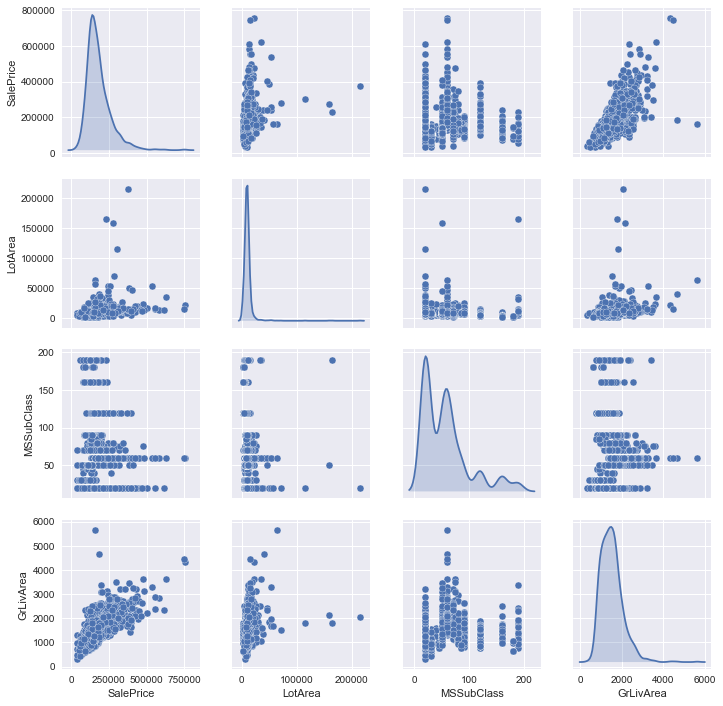

In [4]:
sns.set()
cols = ['SalePrice', "LotArea","MSSubClass", "GrLivArea"]
sns.pairplot(data[cols], size = 2.5, kind='scatter', diag_kind="kde", dropna=True,diag_kws=dict(shade=True))
plt.show()

Some example data exploration from Angela
https://www.kaggle.com/xchmiao/detailed-data-exploration-in-python

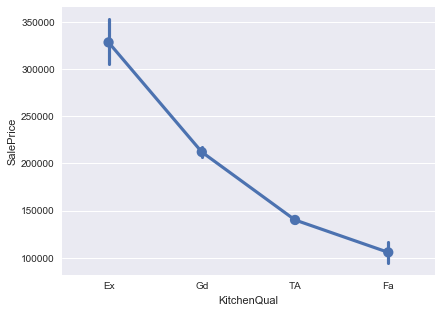

In [5]:
sns.factorplot('KitchenQual', 'SalePrice', estimator = np.mean, 
               size = 4.5, aspect = 1.4, data = data, order = ['Ex', 'Gd', 'TA', 'Fa'])

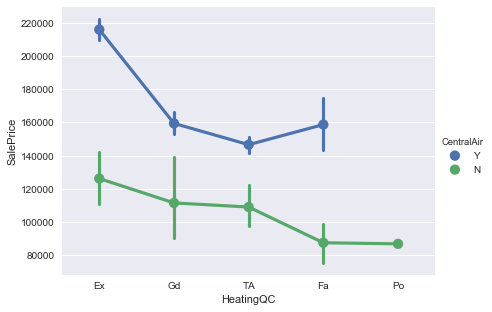

In [6]:
sns.factorplot('HeatingQC', 'SalePrice', hue = 'CentralAir', estimator = np.mean, data = data, 
             size = 4.5, aspect = 1.4)

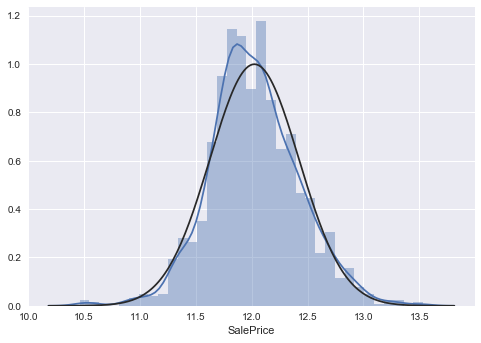

In [7]:
sns.distplot(np.log1p(data.SalePrice),fit=stats.norm)

More visualisations

corr = data.corr()
sns.heatmap(corr)

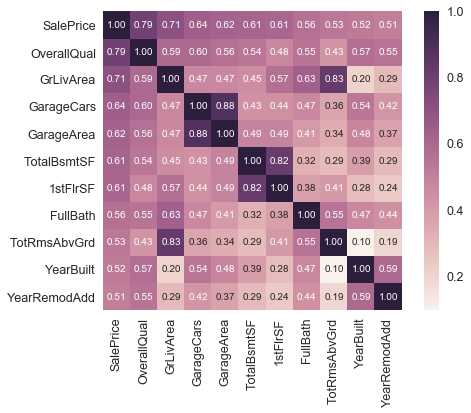

In [8]:
#saleprice correlation matrix
corrmat = data.corr()
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

A bit messy here, but helpful for a quick look at categorical variables

C:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
C:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


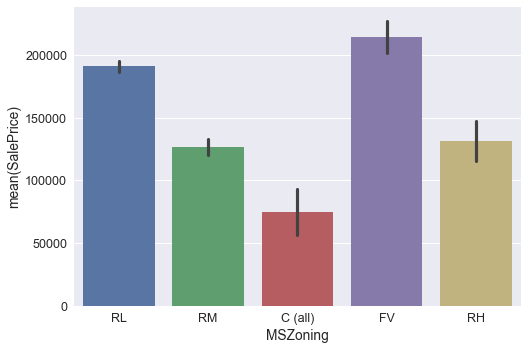

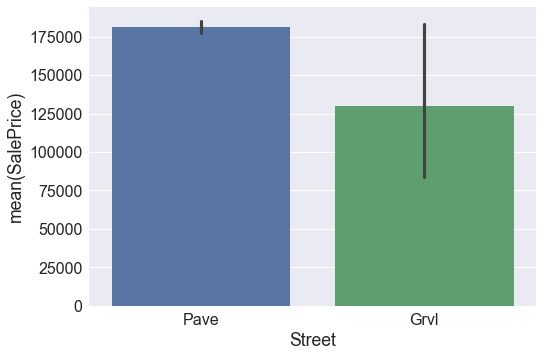

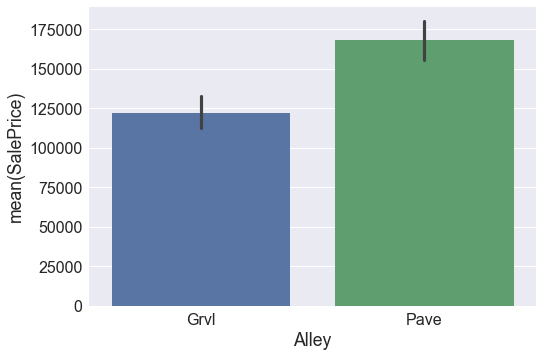

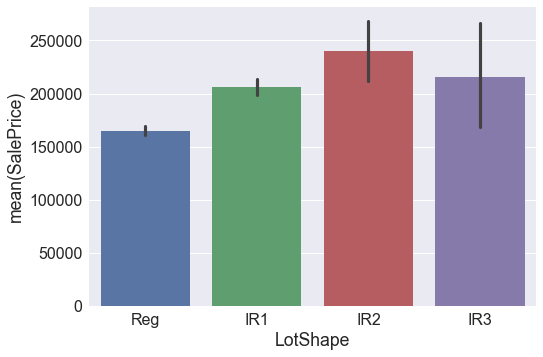

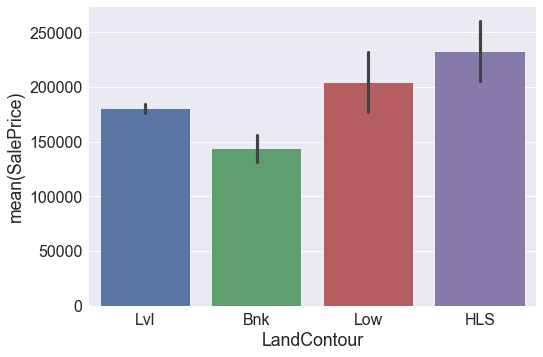

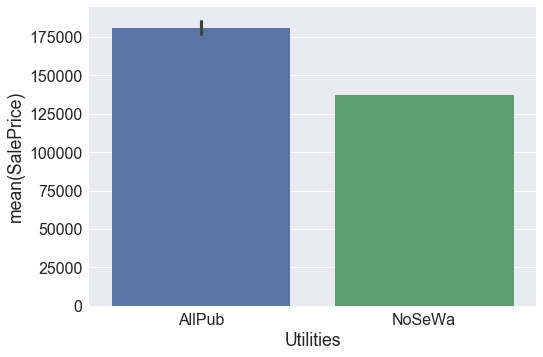

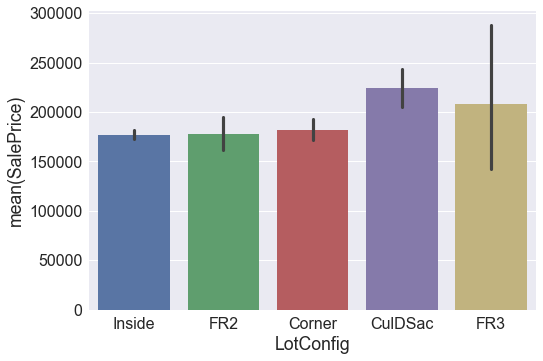

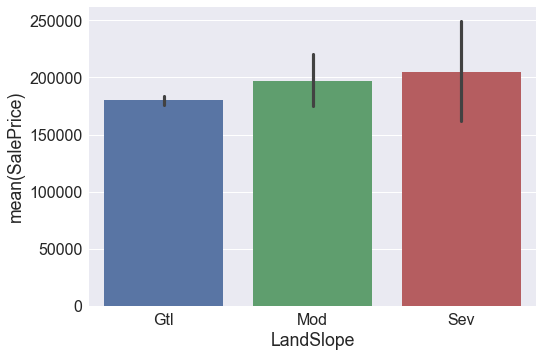

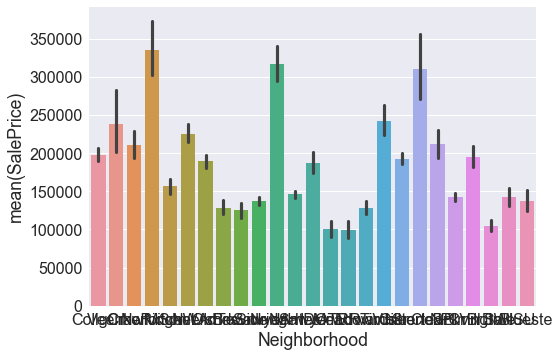

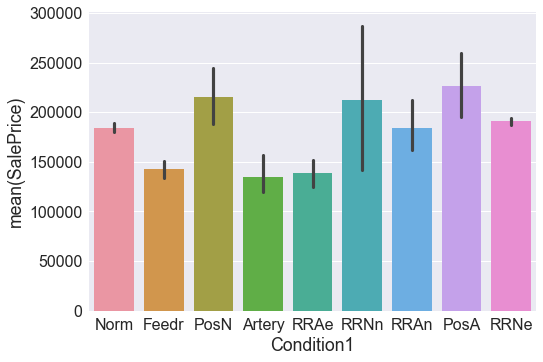

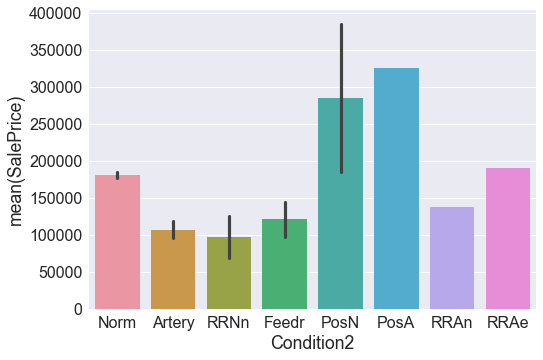

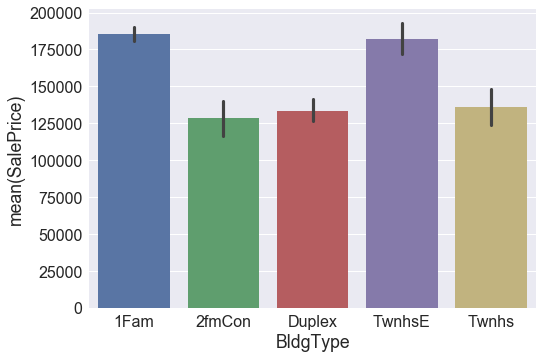

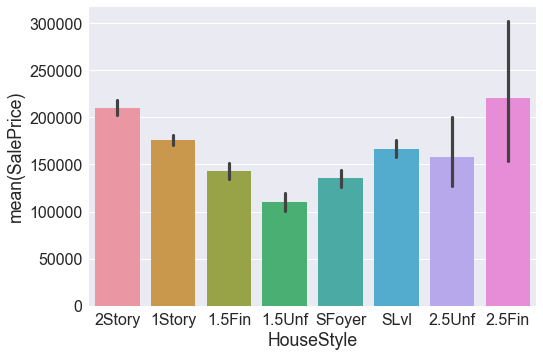

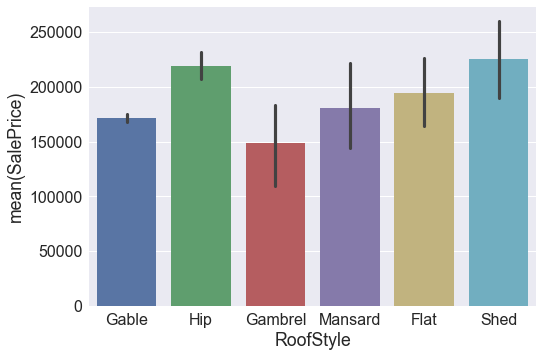

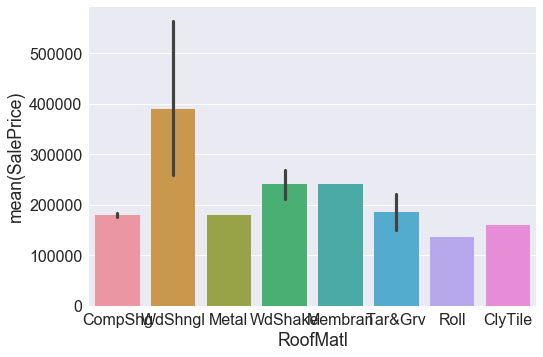

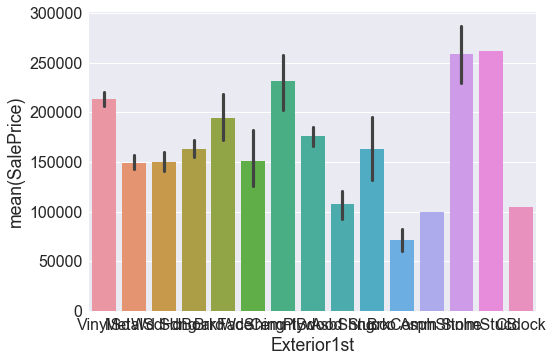

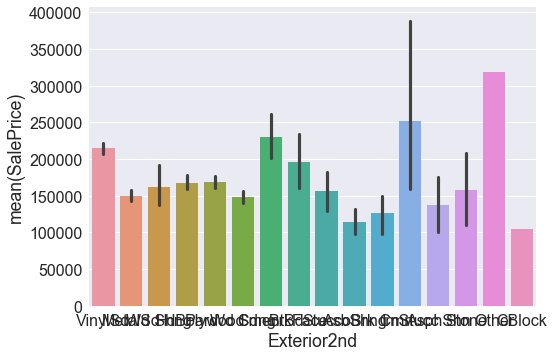

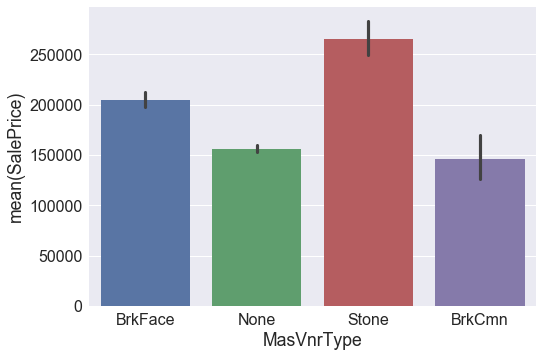

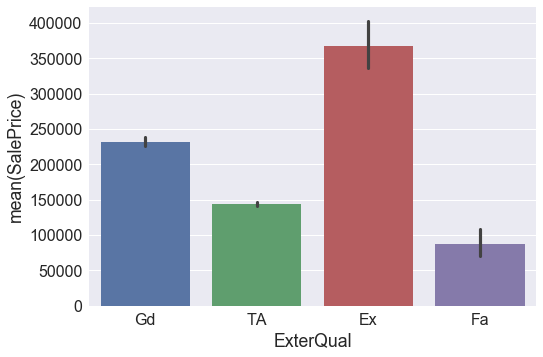

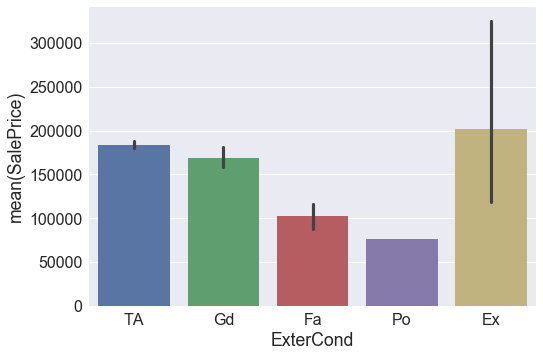

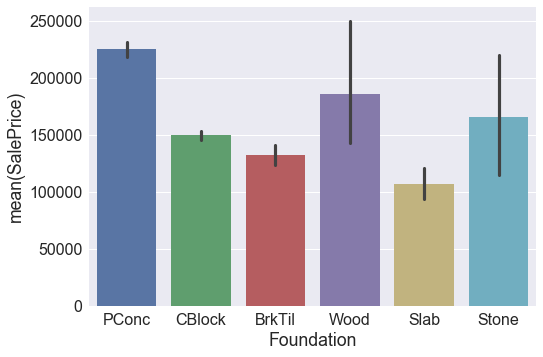

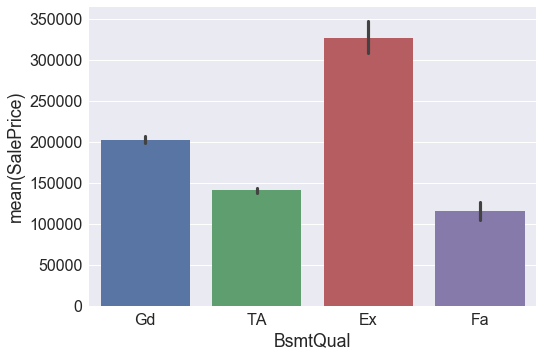

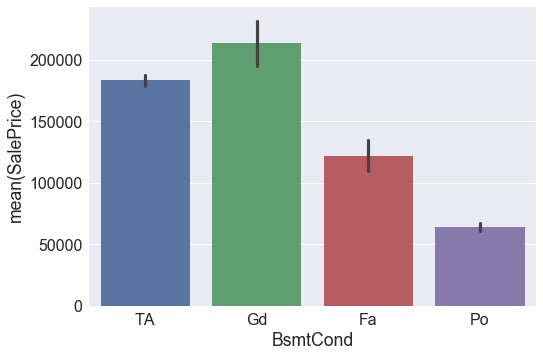

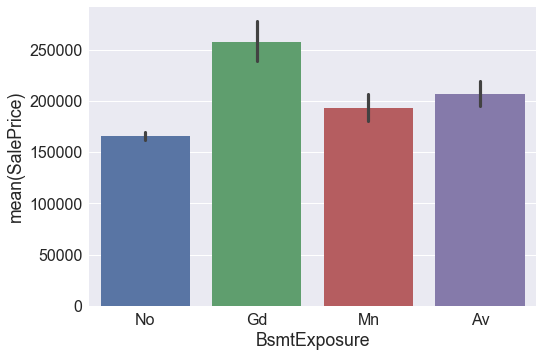

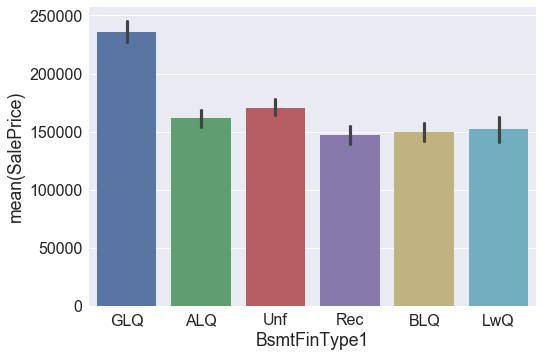

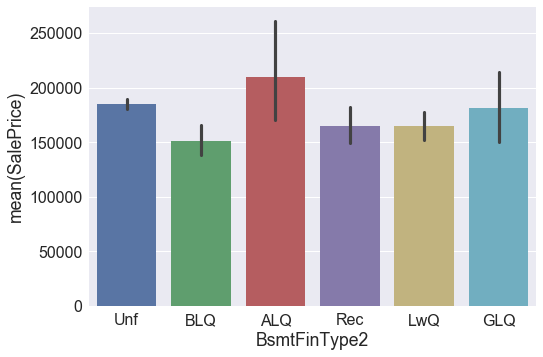

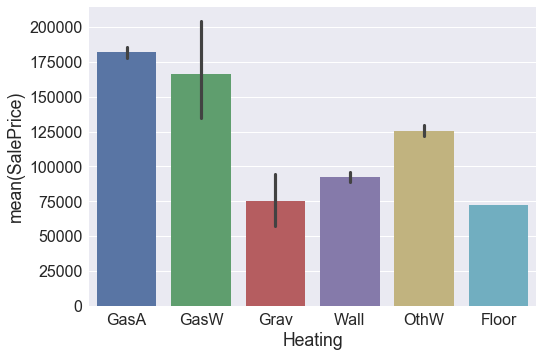

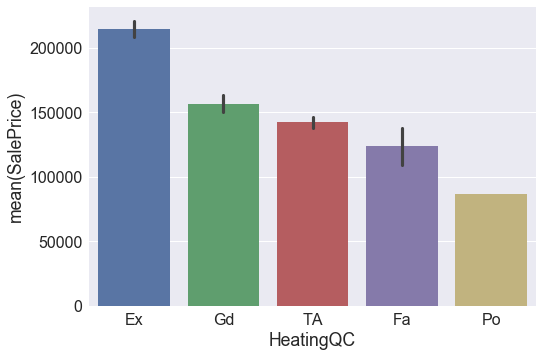

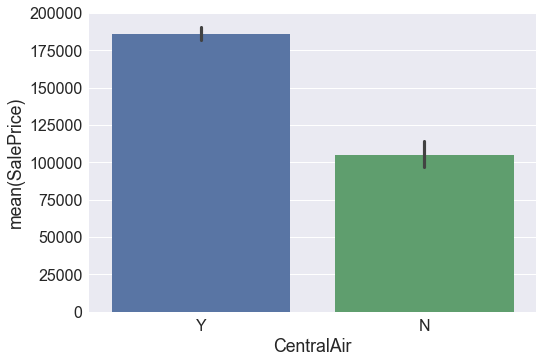

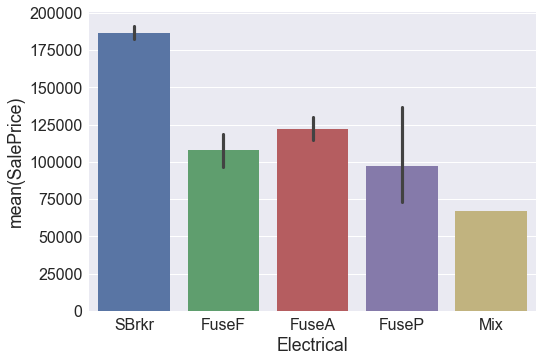

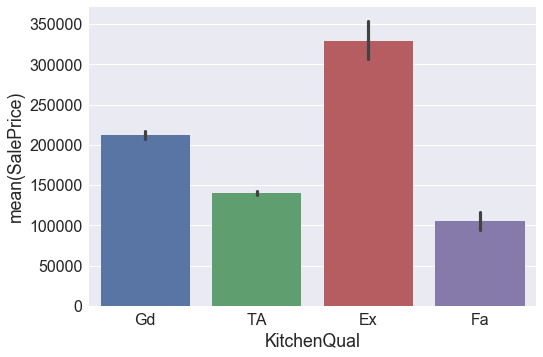

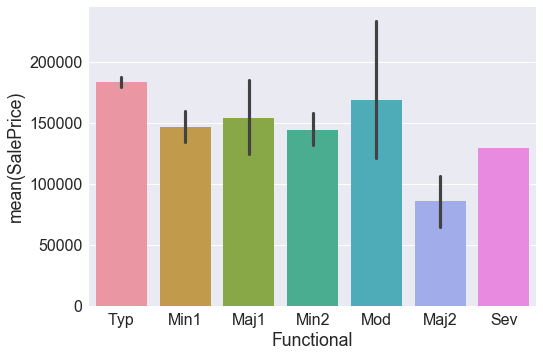

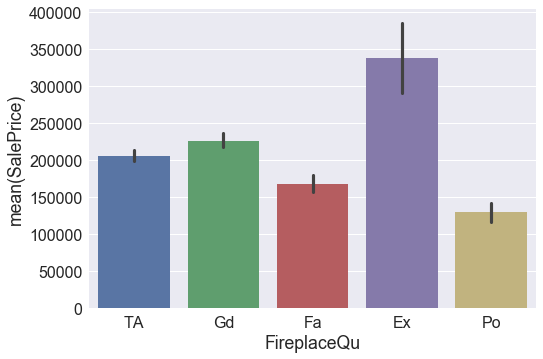

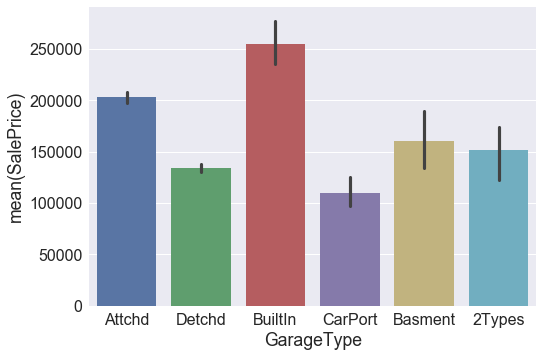

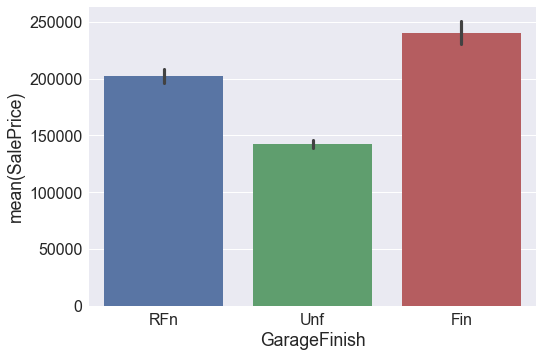

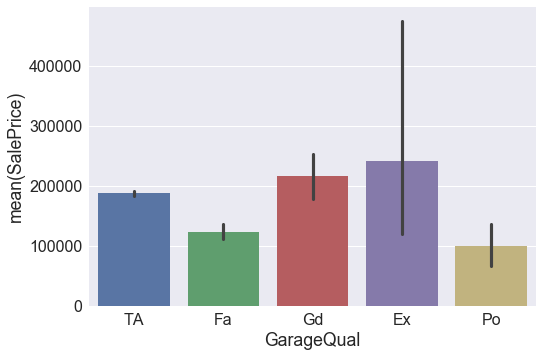

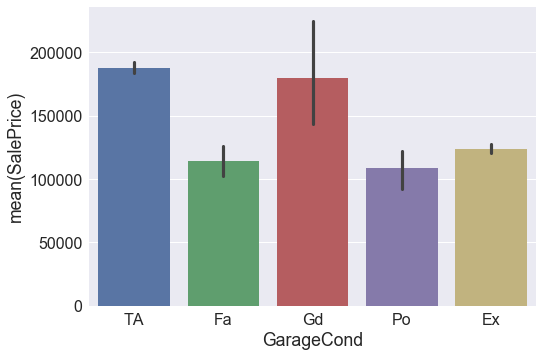

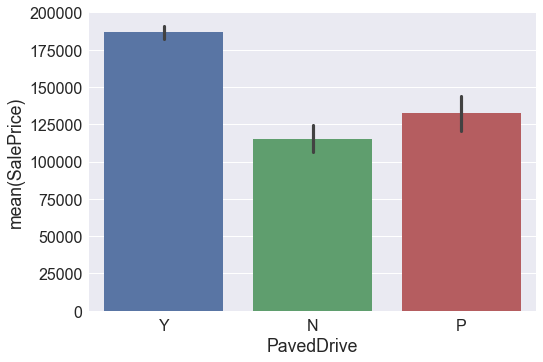

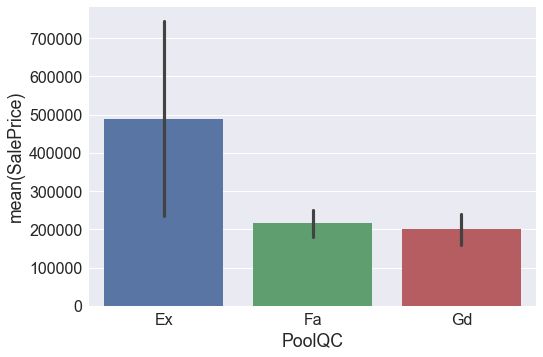

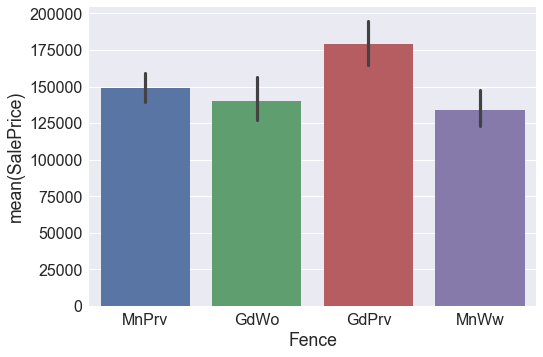

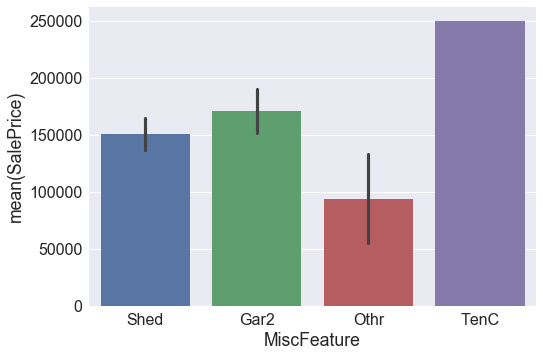

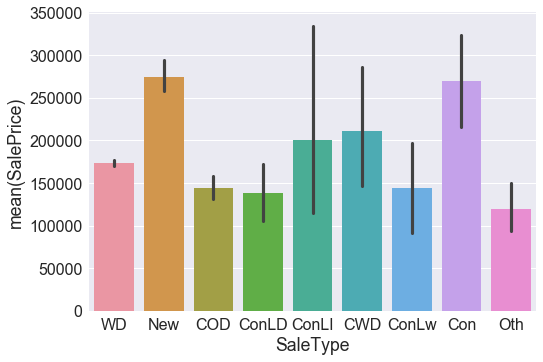

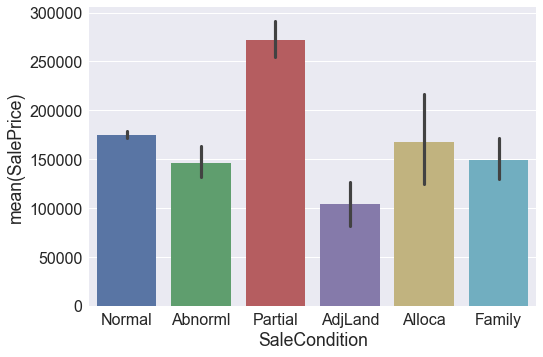

In [9]:
colnames = (data.select_dtypes(['object'])).columns
for c_ in colnames:
    plot_cat(data,c_,"SalePrice",None)

# MANUAL DELETION

First I'll delete some features I dot not want to deal with, or that do not seem useful

In [10]:
features_to_delete = ["GarageYrBlt", "MoSold","MasVnrArea"] #We'll keep this list for a later use
for fd in features_to_delete:
    data = data.drop(fd,axis=1)
    data_validation = data_validation.drop(fd,axis=1)

# CREATION OF NEW FEATURES

In this section I'll create new features, which can also be combination of multiple features to simplify the model. Here I have simply created one new feature which is the "age" of latest works 

In [11]:
#"AgeTravaux" is french for "Number of years since last Remod" ;)
data["AgeTravaux"] = np.abs(data.YrSold-data.YearRemodAdd)
data_validation["AgeTravaux"] = np.abs(data_validation.YrSold-data_validation.YearRemodAdd)
features_to_remove = set()
features_to_remove.add("YearRemodAdd") #This feature is no longer needed

# DATA TRANSFORMATIONS
## Null values
- For categorical : any null value will be set to none "None"
- For numerical : any null value will be replaced by its mean (not the best option, but will give a decent result to start with)

Let's deal with numeric features first

In [12]:
for dat in [data,data_validation]:
    #Let's fetch the names of all numeric features
    colnames_num = (dat.select_dtypes(exclude=[object])).columns
    #Numerical features
    for c_ in colnames_num:
        numeric_null_values(dat,c_)

## Applying various transformations on numeric features

** Boxcox **

In [13]:
#Liste of features to be "boxcox" tranformed (none in this example, but improves score when carefully selected)
boxcox_features = [] #Keep the list of transformed features for later use
for bf in boxcox_features:
    for dat in [data,data_validation]:
        colname = str(bf)
        box = boxcox(dat[colname])
        dat[colname] = box[0]

** Binning **

In [14]:
#List of features to be binned (keep it for later use)
features_bin=["YearBuilt", "AgeTravaux"]
data["YearBuilt"] = pd.cut(data["YearBuilt"],bins=[1872,1940,1960,1980,2000,2010], labels=[1,2,3,4,5]) #Values were taken almost randomly to have ~same number of values in each bin
data_validation["YearBuilt"] = pd.cut(data_validation["YearBuilt"],bins=[1872,1940,1960,1980,2000,2010], labels=[1,2,3,4,5])

** Square **

Applying a square transformation can make small differences more important. For instance, squaring the number of bedrooms will
make sure having 3 bedrooms is much more than 2.

In [15]:
#Liste of features that should be squared
squared_features = ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","Fireplaces"]
for sf in squared_features:
    for dat in [data,data_validation]:
        colname = str(sf)
        dat[colname] = dat[colname].apply(lambda x: x**2)

** Polynomial **

If you look at "GrLivArea" vs "SalePrice", you'll notice that the correlation is not linear. So I'll apply a 2nd order polynomial (via sklearn preprocessing)

I'll create additionnal features

In [16]:
Poly = preprocessing.PolynomialFeatures(degree=2)

polynomial_features = ["GrLivArea"]
for pf in polynomial_features:
    for dat in [data,data_validation]:
        x_ = Poly.fit_transform(dat[pf].values.reshape(-1,1))
        for i in np.arange(1,3):
            colname = pf+"_x_%s"%i
            print(colname)
            dat[colname]=pd.Series(x_[:,i])
            features_to_remove.add(colname) #These are features I do not want to log transform later

GrLivArea_x_1
GrLivArea_x_2
GrLivArea_x_1
GrLivArea_x_2


Now I'll make sure I have a set of all features that were previously transformed. The goal here is to be able to exclude these features from any further transformation

In [17]:
features_transformed = set(polynomial_features)
features_transformed = features_transformed.union(squared_features,features_to_remove, features_bin, boxcox_features)
features_transformed

{'AgeTravaux',
 'BsmtFullBath',
 'BsmtHalfBath',
 'Fireplaces',
 'FullBath',
 'GrLivArea',
 'GrLivArea_x_1',
 'GrLivArea_x_2',
 'HalfBath',
 'YearBuilt',
 'YearRemodAdd'}

As pointed out in other kernels, to reduce skewness, we should apply a log transform on numeric data

In [18]:
#The log should be applied only on numeric features, excluding those already transformed
numeric_features = set((data.select_dtypes(exclude=[object])).columns) #I'll select only numeric features (excluding "objects)

#Taking care not to modify the target or the Id. Not sure if it's a good Idea for "SalePrice", just try and compare scores
numeric_features.remove("SalePrice")
numeric_features.remove("Id")

#Let's keep features that have not been transformed
log_features = numeric_features.difference(features_transformed)
#Let's apply a log transform
for lf in log_features:
    for dat in [data,data_validation]:
        dat[lf]=dat[lf].apply(lambda x:np.log1p(x))

## Categorical features

** Dealing with missing values and proceeding to 1-hot encoding **

In [19]:
for dat in [data,data_validation]:
    #Names of categorical features
    colnames_cat = (dat.select_dtypes(['object'])).columns
    #For categorical features, I'll replace any null value by "None"
    for c_ in colnames_cat:
        cat_null_values(dat,c_)
#Let's create dummy data for both data sets
data = dummy(data)
data_validation = dummy(data_validation)

# Preparing data for writing on disk

I prefer using separate notebooks for data preparation and modelisation. I'll group the two phases here.

In [20]:
features = list(data.columns)
features = [feat for feat in features if feat not in polynomial_features]
#features = [feat for feat in features if feat not in squared_features]
features = [feat for feat in features if feat not in colnames_cat]
len(features)

#Features for validation data (i.e. data used for submission)
features_validation = [feat for feat in features if feat in data_validation.columns]
len(features_validation)

#Features that are not in both data sets
missing_features = list(set(features).difference(features_validation))
missing_features.remove("SalePrice")

features = [feat for feat in features if feat not in missing_features]
features.remove("YearRemodAdd")
features_validation = list(features)
features_validation.remove("SalePrice") #SalePrice is not included in the validation data set

## Writing data in a separate file

In [21]:
data[features].to_csv("2-Prepared Data/data_prep.csv", index=None)
data_validation[features_validation].to_csv("2-Prepared Data/data_validation_prep.csv",index=None)

# +++++++++++++++++++++

# PART 2 : MODELISATION

# +++++++++++++++++++++

** For the modelisation I'll will combine different models that will be fine tuned **

- LASSO
- Elastic Net
- Gradient Boosting
- AdaBoost
- XGBoost

I could use a pipeline combined with a GridSearchCV, but I'll do most of the work manually for clarity

First, let's import the data transformed in the previous part

In [22]:
data = pd.read_csv("2-Prepared Data/data_prep.csv")
data_validation = pd.read_csv("2-Prepared Data/data_validation_prep.csv")

I'll create the features list and define the target here

In [23]:
features = list(data.columns)
features.remove("SalePrice")
target = "SalePrice"
data_Id = data_validation.Id #For later use when writing the final file for submission (see below)

# MANUAL CREATION OF MODELS

We can create and fit several models, estimate their score to compare which would be best suited for our regression problem

In [24]:
train,test = train_test_split(data,test_size=0.2)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [25]:
#ELASTIC NET
ElNet_model = ElasticNetCV(l1_ratio=np.arange(0.05,0.95,0.05),alphas=np.arange(1,100,10),cv=5, max_iter=1500)
ElNet_model.fit(X_train,y_train)
ElNet_pred_test = ElNet_model.predict(X_test)
print("***ELASTIC NET REGRESSOR***\nRMSE on test set : ",RMSE_log(y_test,ElNet_pred_test))
print("R2 for test set : ",r2_score(y_test,ElNet_pred_test))
print("Crossval score : {}".format(cross_val(ElNet_model,data,features)))
coef_EN = pd.Series(ElNet_model.coef_, index = X_train.columns)
print("Elastic net has selected {0} features and deleted {1} features\n".format(sum(coef_EN!=0),sum(coef_EN==0)))

#GBOOST REGRESSOR
GBoost_model = GradientBoostingRegressor(loss="ls",
                                         learning_rate=0.09,
                                         n_estimators=500,
                                        max_depth=4,
                                        alpha=0.08)
GBoost_model.fit(X_train,y_train)
GBoost_pred_test = GBoost_model.predict(X_test)
print("***GRADIENT BOOSTING REGRESSOR*** \nRMSE for test set : ",RMSE_log(y_test,GBoost_pred_test))
print("R2 for test set : {}".format(r2_score(y_test,GBoost_pred_test)))
print("Crossval score : {}\n".format(cross_val(GBoost_model,data,features)))


#ADABOOST REGRESSOR
AdaBoost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.7, loss="exponential")
AdaBoost_model.fit(X_train,y_train)
AdaBoost_pred_test = AdaBoost_model.predict(X_test)
print("***ADABOOST REGRESSOR***\nRMSE for test set : ",RMSE_log(y_test,AdaBoost_pred_test))
print("R2 pour le test set : {}".format(r2_score(y_test,AdaBoost_pred_test)))
print("Crossval score : {}\n".format(cross_val(AdaBoost_model,data,features)))

#XGBoost REGRSSOR
xgb_model = XGBRegressor(n_estimators=1000,max_depth=3,learning_rate=0.05)
xgb_model.fit(X_train,y_train)
xgb_pred_test = xgb_model.predict(X_test)
print("***XGBOOST REGRESSOR*** \nRMSE pour le test set : {}".format(RMSE_log(y_test,xgb_pred_test)))
print("R2 pour le test set : {}".format(r2_score(y_test,xgb_pred_test)))
print("Crossval score : {}\n".format(cross_val(xgb_model,data,features)))

lasso_model = Lasso(alpha=150,max_iter=3000)
lasso_model.fit(X_train,y_train)
lasso_pred = lasso_model.fit(X_test,y_test)
lasso_pred = lasso_model.predict(X_test)
print("***LASSO REGRESSOR***: {}".format(RMSE_log(pred=lasso_pred,true=y_test)))
print("LASSO has eliminated {0} features and kept {1}".format((lasso_model.coef_ == 0).sum(),(lasso_model.coef_ != 0).sum()))
print("Crossval score : {}".format(cross_val(lasso_model,data,features)))


***ELASTIC NET REGRESSOR***
RMSE on test set :  0.157791014389
R2 for test set :  0.86234417799
Crossval score : 0.8164252582701318
Elastic net has selected 284 features and deleted 3 features

***GRADIENT BOOSTING REGRESSOR*** 
RMSE for test set :  0.130935566405
R2 for test set : 0.9084794547241083
Crossval score : 0.8889369943512453

***ADABOOST REGRESSOR***
RMSE for test set :  0.215962821829
R2 pour le test set : 0.8176448150205597
Crossval score : 0.8107057789454295

***XGBOOST REGRESSOR*** 
RMSE pour le test set : 0.12794709974354196
R2 pour le test set : 0.9131047483457012
Crossval score : 0.8854426709728298

***LASSO REGRESSOR***: 0.10398602717669546
LASSO has eliminated 195 features and kept 92
Crossval score : 0.8493622839892223


Here we can see that boosting techniques (XGBoost and Gradient boosting) performed much better than the other techniques. Adaboost did not perform as well as other boosting techniques.

Before going further, let's quickly examine the coefs for elastic net :

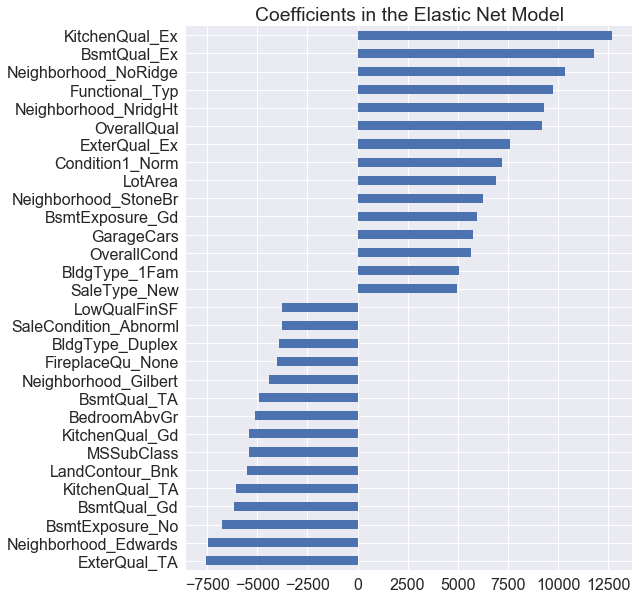

In [26]:
coef = pd.Series(ElNet_model.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(15),
                     coef.sort_values().tail(15)])

plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

Well, I'm not really convinced by elastic net here. The kichen's quality would really be the highest positive weight ?

To be honest, I have run this model several times previously and generally the best features are Overall quality of the house, areas, etc. I'll be lazy here and not run the model once again to fine tune parameters, but you get the idea ;)

Let's do the same with Lasso :

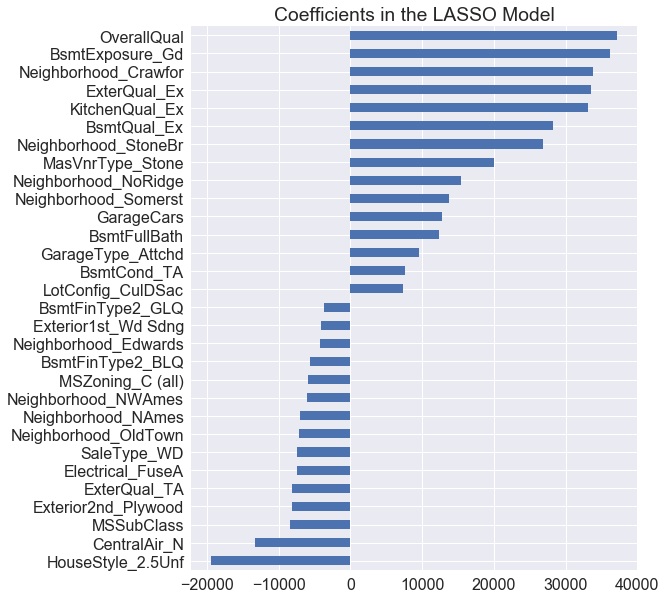

In [27]:
coef = pd.Series(lasso_model.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(15),
                     coef.sort_values().tail(15)])

plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the LASSO Model")

In my opinion this looks much better, although this would need some finetuning (check below)

Now we can try to combine these models into an ensemble regressor to yield a mean prediction.

An interesting technique could be to weight these predictions (e.g. 0.8*GradBoost + 0.1*LASSO + 0.1*ElasticNet). But we'll keep it simple here

## ENSEMBLE REGRESSOR

In [28]:
#Prédiction on the test set for testing/checking purpose
#In the "EnsembleRegressor" function, simply pass any combination of models you want
predTestSet = EnsembleRegressor([GBoost_model, ElNet_model,lasso_model,xgb_model], X_test)
print("***ENSEMBLE REGRESSOR***\nRMSE for test set : {}".format(RMSE_log(pred=predTestSet.Ensemble,true=y_test)))

#Prédiction finale
Final_answer = EnsembleRegressor([GBoost_model, ElNet_model,lasso_model,xgb_model],data_validation[features])
Final_answer = Final_answer
data_validation["Id"] = data_Id #Yes, this is why I put aside "Id" at the beginning of the Notebook

***ENSEMBLE REGRESSOR***
RMSE for test set : 0.11377675784396403


I have created a DataFrame that keeps track of all prediction and whose last column is the mean of all models

In [29]:
Final_answer.head()

,Grad,Elas,Lass,XGBR,Ensemble
0,130151.684707,100676.584431,108995.558780,127410.914062,116808.685495
1,164478.211323,156603.232623,126809.066859,165068.203125,153239.678483
2,180452.103105,203767.692554,168626.455345,182924.593750,183942.711189
3,195455.247088,208674.327798,174900.156369,194524.468750,193388.550001
4,184925.262209,178332.937568,204101.580526,189804.390625,189291.042732


# SUBMISSION

OK, it's been a lot of work, we can now write the final csv file and submit the prediction

In [30]:
writePredFile(data_validation,Final_answer["Ensemble"],"filename.csv")

# +++++++++++++++++++++

# EXTRA STUFF

# +++++++++++++++++++++

# PARAMETERS OPTIMISATION

You might wonder how I have chosen the parameters of all the models ? You're right, I did not guess !

I have used a brute force search method : GridSearch. For each model, you can feed a grid of parameters, that will be all evaluated and the best parameters will be displayed

Be warned though that a too fine finetuning can lead to overfitting ;)

With my "OptimiseParameters" function you simply have to feed a grid of parameters to launch the search

In [31]:
#I have put few parameters here to speed up the procedure but you should definitely use a larger grid
param_grid = { 
    'loss' : ["ls","huber"],
    'learning_rate': np.arange(0.02,0.22,0.1),
    'min_samples_leaf':[1,2],
    'n_estimators':[150],
    'max_depth':[3],
    'alpha':np.arange(0.02,0.12,0.1)
}
CV_model, bscore,bparams = OptimiseParameters(GradientBoostingRegressor,X_train,y_train,parameters=param_grid, n_jobs=2)## Optimisation des hyperparamètres pour Gradient Boosting

Execution time: 45.74962878227234

Best parameters: {'n_estimators': 150, 'max_depth': 3, 'loss': 'ls', 'alpha': 0.02, 'min_samples_leaf': 1, 'learning_rate': 0.12000000000000001}
 
Best R2 score: 0.8769562691185147

Best estimator: GradientBoostingRegressor(alpha=0.02, criterion='friedman_mse', init=None,
             learning_rate=0.12000000000000001, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)



# MANAGING OUTLIERS

Using the code below for outliers detection and deletion can help improve the score a little. I'll leave it to you as an exercise ;)

In [32]:
# 'contamination' is for controlling the cluster's size : the larger the cluster the 
clf = IsolationForest(contamination=0.05)
#clf.fit(data.select_dtypes(exclude=['object']))
#pred_outlier = clf.predict(data.select_dtypes(exclude=['object']))
X = pd.DataFrame()
X["LotArea"] = data.LotArea
X["SalePrice"] = data.SalePrice
clf.fit(X)
pred_outlier = clf.predict(X)
print("Number of outliers : ",(len(pred_outlier)-pred_outlier.sum())/2)
data["Outlier"] = pred_outlier

Number of outliers :  73.0


We can check which observations have been deleted, for instance for "LotArea"

White dots are observations that were classified as outliers

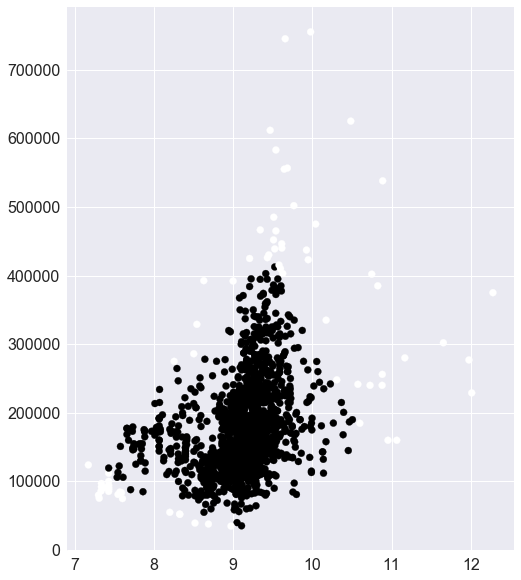

In [33]:
plt.scatter(data.LotArea, data.SalePrice, c=data.Outlier)

To remove outliers from the data set

In [34]:
data = data.query('Outlier==1')
data = data.drop('Outlier', axis=1)

# MANUALLY PIPELINING A LASSO AND GRADIENT BOOSTING

I put this piece of code here, but I haven't used it to make a submission.

The idea is to run a lasso with different values of alpha (i.e. less features will be selected), then remove extra features from the initial list of features and feed it into a Gradient boosting regressor.



In [52]:
init_features = list(data.columns) #All features
init_features.remove("SalePrice")
alphas = [40,60,80]
GB_score = []
Lasso_score = []
for a in alphas:
    features = list(init_features)
    print("*** FEATURES SELECTION WITH LASSO ***")
    train,test = train_test_split(data,test_size=0.2)
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    lasso_model = Lasso(a, max_iter=3000)
    lasso_model.fit(X_train,y_train)
    lasso_pred = lasso_model.fit(X_test,y_test)
    lasso_pred = lasso_model.predict(X_test)

    #print("Le score RMSE pour le lasso: {}".format(RMSE_log(pred=lasso_pred,true=y_test)))
    print("LASSO has eliminated {0} features and kept {1}\nAlpha={2}".format((lasso_model.coef_ == 0).sum(),(lasso_model.coef_ != 0).sum(),a))
    cscorelasso = cross_val(lasso_model,data,features)
    
    print("Crossval score LASSO: {}\n".format(cscorelasso))
    Lasso_score.append(cscorelasso)
    zero_coef=[]
    for i in range(len(features)):
        #print("{0}  \t Coef : {1}".format(features[i],lasso_model.coef_[i]))
        if lasso_model.coef_[i] != 0:
            zero_coef.append(features[i])
    len(zero_coef) #Ca correspond bien au nombre de features conservées par LASSO
    features = list(zero_coef)
    
    #On fit un modèle XGBOOST sur les différentes valeurs de alpha et avec de nouvelles features
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
   
    #GBOOST REGRESSOR
    GBoost_model = GradientBoostingRegressor(loss="ls",
                                         learning_rate=0.1,
                                         n_estimators=300,
                                        max_depth=4,
                                        alpha=0.15)
    GBoost_model.fit(X_train,y_train)
    GBoost_pred_test = GBoost_model.predict(X_test)
    print("***GRADIENT BOOSTING REGRESSOR*** \nRMSE for test set : ",RMSE_log(y_test,GBoost_pred_test))
    print("R2 pour le test set : {}".format(r2_score(y_test,GBoost_pred_test)))
    cscore_GB = cross_val(GBoost_model,data,features)
    print("Crossval score GBoost : {}\n".format(cscore_GB))
    GB_score.append(cscore_GB)

print("Max GBoost: {0}, max Lasso: {1}".format(max(GB_score), max(Lasso_score)))

*** FEATURES SELECTION WITH LASSO ***
LASSO has eliminated 137 features and kept 150
Alpha=40
Crossval score LASSO: 0.9042109265640516

***GRADIENT BOOSTING REGRESSOR*** 
RMSE for test set :  0.126784166869
R2 pour le test set : 0.8751937731311079
Crossval score GBoost : 0.8874745978904833

*** FEATURES SELECTION WITH LASSO ***
LASSO has eliminated 155 features and kept 132
Alpha=60
Crossval score LASSO: 0.9039398770412405

***GRADIENT BOOSTING REGRESSOR*** 
RMSE for test set :  0.134345688721
R2 pour le test set : 0.870865217691678
Crossval score GBoost : 0.8897674617264377

*** FEATURES SELECTION WITH LASSO ***
LASSO has eliminated 169 features and kept 118
Alpha=80
Crossval score LASSO: 0.9030909568632046

***GRADIENT BOOSTING REGRESSOR*** 
RMSE for test set :  0.0987338409537
R2 pour le test set : 0.9267340579166817
Crossval score GBoost : 0.895599778928952

Max GBoost: 0.895599778928952, max Lasso: 0.9042109265640516


Please do not hesitate to comment this notebook. I guess many improvements can be made.